In [2]:
import sys
!pip install pandas
import pandas as pd
import numpy as np
import nltk


import re
import nltk
from joblib import dump, load
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=200
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # Asegúrate de importar StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score




import scipy.stats as stats
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold

# Metricas
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# q-q plots
import scipy.stats as stats

In [3]:
!pip install LightFM
from lightfm import LightFM
from lightfm.data import Dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LightFM: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831161 sha256=19b2e0337b21ef3840727914a1f27cb438118ffb558375750de74f03ad557b92
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built LightFM


## Carga de datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pd2 = pd.read_csv('/content/drive/MyDrive/Corona/b2b_nuevo.csv' , sep=",", encoding="utf-8")

In [6]:

b2b = pd2.copy()

## Implementación B2B

In [7]:
print(b2b.columns.tolist())

['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b', 'producto', 'valor_total', 'alineación con portafolio estratégico b2b', 'Total de unidades', 'Total de edificaciones en obra']


In [8]:
categorical_cols = b2b.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro',
       'categoria_b2b', 'subcategoria_b2b', 'producto'],
      dtype='object')


In [9]:
desired_columns = ['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b', 'producto', 'valor_total', 'alineación con portafolio estratégico b2b']
b2b_small = b2b[desired_columns].copy()
b2b_small

,fecha_factura,id_b2b,municipio,zona,categoria_b2b_macro,categoria_b2b,subcategoria_b2b,producto,valor_total,alineación con portafolio estratégico b2b
0,2007-01-03,B2B_01,MADRID,CUNDINAMARCA,cat_b2b_macro_1,cat_b2b_1,sub_b2b_1,Producto_1,1819.931192,0.000216
1,2007-01-03,B2B_01,MADRID,CUNDINAMARCA,cat_b2b_macro_1,cat_b2b_1,sub_b2b_1,Producto_2,1713.359382,0.000077
2,2007-01-04,B2B_02,VILLA DE LEYVA,BOYACA,cat_b2b_macro_2,cat_b2b_3,sub_b2b_3,Producto_4,208.510406,0.000069
3,2007-01-04,B2B_02,VILLA DE LEYVA,BOYACA,cat_b2b_macro_1,cat_b2b_1,sub_b2b_11,Producto_13,3319.449852,0.000308
4,2007-01-04,B2B_02,VILLA DE LEYVA,BOYACA,cat_b2b_macro_1,cat_b2b_1,sub_b2b_12,Producto_14,4945.685288,0.000110
...,...,...,...,...,...,...,...,...,...,...
25861,2010-02-18,B2B_05,FUSAGASUGA,CUNDINAMARCA,cat_b2b_macro_11,cat_b2b_14,sub_b2b_23,Producto_66,303.853648,0.000654
25862,2010-02-18,B2B_05,FUSAGASUGA,CUNDINAMARCA,cat_b2b_macro_14,cat_b2b_14,sub_b2b_23,Producto_809,85.641002,0.000654
25863,2010-02-18,B2B_05,FUSAGASUGA,CUNDINAMARCA,cat_b2b_macro_15,cat_b2b_15,sub_b2b_24,Producto_1049,75.615354,0.000654
25864,2010-02-18,B2B_06,TUNJA,BOYACA,cat_b2b_macro_1,cat_b2b_1,sub_b2b_43,Producto_1255,2640.812674,0.000654


### Manejo Categóricas

Fue necesario darle un manejo distinto a las variables categóricas, ya que al tener tantas categorías perjudican e imposibilitan la elaboración del modelo de recomendación

In [10]:
cat_cols = ['id_b2b', 'municipio', 'zona', 'categoria_b2b_macro',
       'categoria_b2b', 'subcategoria_b2b', 'producto']

Se utiliza la técnica de Label Encoder

In [11]:
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    b2b[f'{col}_enc'] = le.fit_transform(b2b[col].astype(str))
    b2b_small[f'{col}_enc'] = le.transform(b2b_small[col].astype(str))
    label_encoders[col] = le


## Pipeline LightFM

In [12]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import numpy as np

b2b[cat_cols] = b2b[cat_cols].astype(str)

# Inicialización
dataset = Dataset()
dataset.fit(
    users=b2b['id_b2b'].unique(),
    items=b2b['producto'].unique()
)


dataset.fit_partial(
    users=b2b['id_b2b'],
    items=b2b['producto'],
    user_features=np.unique([
        *("municipio:" + b2b['municipio']),
        *("zona:" + b2b['zona']),
        *("unidades:" + b2b['Total de unidades'].astype(str)),
        *("edificaciones:" + b2b['Total de edificaciones en obra'].astype(str))
    ]),
    item_features=np.unique([
        *("cat_macro:" + b2b['categoria_b2b_macro']),
        *("cat:" + b2b['categoria_b2b']),
        *("subcat:" + b2b['subcategoria_b2b'])
    ])
)


# Interacciones
(interactions, _) = dataset.build_interactions(
    ((row['id_b2b'], row['producto'], row['valor_total']) for _, row in b2b.iterrows())
)

# User features
user_features = dataset.build_user_features(
    ((row['id_b2b'], [
        f"municipio:{row['municipio']}",
        f"zona:{row['zona']}",
        f"unidades:{row['Total de unidades']}",
        f"edificaciones:{row['Total de edificaciones en obra']}"
    ]) for _, row in b2b.iterrows())
)

# Item features
item_features = dataset.build_item_features(
    ((row['producto'], [
        f"cat_macro:{row['categoria_b2b_macro']}",
        f"cat:{row['categoria_b2b']}",
        f"subcat:{row['subcategoria_b2b']}"
    ]) for _, row in b2b.iterrows())
)

# Entrenamiento
model_lfm = LightFM(loss='warp')
model_lfm.fit(interactions,
          user_features=user_features,
          item_features=item_features,
          epochs=10,
          num_threads=4)

# Evaluación
precision = precision_at_k(model_lfm, interactions, user_features=user_features,
                           item_features=item_features, k=5).mean()
recall = recall_at_k(model_lfm, interactions, user_features=user_features,
                     item_features=item_features, k=5).mean()
auc = auc_score(model_lfm, interactions, user_features=user_features,
                item_features=item_features).mean()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 1.0000
Recall: 0.0048
AUC: 0.8578


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metricas_lfm_b2b = {
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "AUC": round(auc, 4)
}

In [14]:

user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()


usuario = list(user_id_map.keys())[2]
usuario_idx = user_id_map[usuario]


n_items = len(item_id_map)


scores = model_lfm.predict(
    usuario_idx,
    np.arange(n_items),
    user_features=user_features,
    item_features=item_features
)


top_items_idx = np.argsort(-scores)


reverse_item_map = {v: k for k, v in item_id_map.items()}
top_productos = [reverse_item_map[i] for i in top_items_idx[:10]]

print(f"Recomendaciones para usuario {usuario}:\n", top_productos)


Recomendaciones para usuario B2B_03:
 ['Producto_1139', 'Producto_1053', 'Producto_1054', 'Producto_552', 'Producto_553', 'Producto_1411', 'Producto_801', 'Producto_1361', 'Producto_779', 'Producto_1388']


### Modelo LightFM sin Extras

In [15]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import numpy as np

b2b_small[cat_cols] = b2b_small[cat_cols].astype(str)

# Inicialización
dataset = Dataset()
dataset.fit(
    users=b2b_small['id_b2b'].unique(),
    items=b2b_small['producto'].unique()
)


dataset.fit_partial(
    users=b2b_small['id_b2b'],
    items=b2b_small['producto'],
    user_features=np.unique([
        *("municipio:" + b2b_small['municipio']),
        *("zona:" + b2b_small['zona'])
    ]),
    item_features=np.unique([
        *("cat_macro:" + b2b_small['categoria_b2b_macro']),
        *("cat:" + b2b_small['categoria_b2b']),
        *("subcat:" + b2b_small['subcategoria_b2b'])
    ])
)


# Interacciones
(interactions, _) = dataset.build_interactions(
    ((row['id_b2b'], row['producto'], row['valor_total']) for _, row in b2b_small.iterrows())
)

# User features
user_features2 = dataset.build_user_features(
    ((row['id_b2b'], [
        f"municipio:{row['municipio']}",
        f"zona:{row['zona']}"
    ]) for _, row in b2b_small.iterrows())
)

# Item features
item_features2 = dataset.build_item_features(
    ((row['producto'], [
        f"cat_macro:{row['categoria_b2b_macro']}",
        f"cat:{row['categoria_b2b']}",
        f"subcat:{row['subcategoria_b2b']}"
    ]) for _, row in b2b_small.iterrows())
)

# Entrenamiento
model_lfm2 = LightFM(loss='warp')
model_lfm2.fit(interactions,
          user_features=user_features2,
          item_features=item_features2,
          epochs=10,
          num_threads=4)

# Evaluación
precision = precision_at_k(model_lfm2, interactions, user_features=user_features2,
                           item_features=item_features2, k=5).mean()
recall = recall_at_k(model_lfm2, interactions, user_features=user_features2,
                     item_features=item_features2, k=5).mean()
auc = auc_score(model_lfm2, interactions, user_features=user_features2,
                item_features=item_features2).mean()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")



Precision: 0.8667
Recall: 0.0034
AUC: 0.8657


## Modelo Tabular

In [16]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd
import itertools

# --- Preprocesamiento ---
b2b[cat_cols] = b2b[cat_cols].astype(str)
b2b['comprado'] = 1

# --- Construcción de universo completo cliente-producto ---
clientes = b2b['id_b2b'].unique()
productos = b2b['producto'].unique()

combinaciones = pd.DataFrame(list(itertools.product(clientes, productos)), columns=['id_b2b', 'producto'])

# Marcar los comprados reales
comprados = b2b[['id_b2b', 'producto']].drop_duplicates()
comprados['comprado'] = 1

# Merge para crear dataset con comprados y no comprados
df_all = combinaciones.merge(comprados, on=['id_b2b', 'producto'], how='left')
df_all['comprado'] = df_all['comprado'].fillna(0)

# Filtrar: muestreamos mismos positivos y mismos negativos para balancear
positivos_df = df_all[df_all['comprado'] == 1]
negativos_df = df_all[df_all['comprado'] == 0].sample(n=len(positivos_df), random_state=42)
df_final = pd.concat([positivos_df, negativos_df], ignore_index=True)

# --- Enriquecer con info de cliente y producto ---
cliente_info = b2b.drop_duplicates('id_b2b').set_index('id_b2b')[[
    'municipio', 'zona', 'valor_total', 'Total de unidades', 'Total de edificaciones en obra'
]]
producto_info = b2b.drop_duplicates('producto').set_index('producto')[[
    'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b'
]]

df_final = df_final.join(cliente_info, on='id_b2b')
df_final = df_final.join(producto_info, on='producto')

# --- Codificación ---
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    encoders[col] = le

# --- Split en entrenamiento y holdout balanceado ---
positivos_df = df_final[df_final['comprado'] == 1]
negativos_df = df_final[df_final['comprado'] == 0]

train_pos, test_pos = train_test_split(positivos_df, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(negativos_df, test_size=0.2, random_state=42)

train_df = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_pos, test_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_df.drop(columns=['comprado'])
y_train = train_df['comprado']
X_test = test_df.drop(columns=['comprado'])
y_test = test_df['comprado']

# --- Modelo con regularización ---
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

# --- Validación cruzada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"\nAUC promedio (5-fold CV): {scores.mean():.4f}")
print(f"AUC por fold: {np.round(scores, 4)}")

# --- Evaluación final con holdout ---
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación (holdout):\n", classification_report(y_test, y_pred))
print("AUC (holdout):", roc_auc_score(y_test, y_prob))



AUC promedio (5-fold CV): 0.8735
AUC por fold: [0.873  0.8827 0.876  0.8691 0.8666]

Reporte de Clasificación (holdout):
               precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       977
         1.0       0.80      0.76      0.78       977

    accuracy                           0.79      1954
   macro avg       0.79      0.79      0.79      1954
weighted avg       0.79      0.79      0.79      1954

AUC (holdout): 0.8733181495795309


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metricas_xgb_b2b = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "AUC (holdout)": roc_auc_score(y_test, y_prob),
    "AUC (5-fold CV)": scores.mean()
}


In [18]:
def recomendar_productos(id_b2b, modelo, df_original, df_codificado, encoders, top_n=5):
    # Filtrar productos ya comprados por el cliente
    productos_comprados = df_original[df_original['id_b2b'] == id_b2b]['producto'].unique()
    todos_los_productos = df_original['producto'].unique()
    productos_no_comprados = [p for p in todos_los_productos if p not in productos_comprados]

    if not productos_no_comprados:
        return f"Cliente {id_b2b} ya ha comprado todos los productos."

    # Tomar una muestra representativa del cliente
    cliente_info = df_original[df_original['id_b2b'] == id_b2b].iloc[0]

    # Generar filas nuevas combinando cliente con cada producto no comprado
    nuevas_filas = []
    for producto in productos_no_comprados:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Eliminar columnas de producto si ya existen antes del join
    columnas_producto = ['categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b']
    pred_df = pred_df.drop(columns=[col for col in columnas_producto if col in pred_df.columns], errors='ignore')

    # Agregar info del producto
    producto_info = df_original.drop_duplicates('producto').set_index('producto')[columnas_producto]
    pred_df = pred_df.set_index('producto').join(producto_info, on='producto').reset_index()

    # Codificar
    for col in encoders:
        if col in pred_df.columns:
            pred_df[col] = encoders[col].transform(pred_df[col])

    # Predecir
    X_pred = pred_df[modelo.get_booster().feature_names]
    proba = modelo.predict_proba(X_pred)[:, 1]
    pred_df['probabilidad'] = proba

    # Decodificar producto
    producto_le = encoders['producto']
    pred_df['producto_nombre'] = producto_le.inverse_transform(pred_df['producto'])

    return pred_df[['producto_nombre', 'probabilidad']].sort_values(by='probabilidad', ascending=False).head(top_n)


In [19]:
print(b2b['id_b2b'].unique())


['B2B_01' 'B2B_02' 'B2B_03' 'B2B_04' 'B2B_05' 'B2B_06']


In [20]:
recomendar_productos('B2B_01', model, b2b, df_final, encoders, top_n=10)


,producto_nombre,probabilidad
66,Producto_317,0.797145
65,Producto_316,0.792060
61,Producto_310,0.765170
1016,Producto_1566,0.761069
975,Producto_1498,0.759338
984,Producto_1509,0.759338
1006,Producto_1542,0.754916
68,Producto_323,0.750831
1103,Producto_1694,0.748766
1100,Producto_1686,0.746566


## XGBOOST sin extras

In [21]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd
import itertools

# --- Preprocesamiento ---
b2b_small[cat_cols] = b2b_small[cat_cols].astype(str)
b2b_small['comprado'] = 1

# --- Construcción de universo completo cliente-producto ---
clientes = b2b_small['id_b2b'].unique()
productos = b2b_small['producto'].unique()

combinaciones = pd.DataFrame(list(itertools.product(clientes, productos)), columns=['id_b2b', 'producto'])

# Marcar los comprados reales
comprados = b2b_small[['id_b2b', 'producto']].drop_duplicates()
comprados['comprado'] = 1

# Merge para crear dataset con comprados y no comprados
df_all = combinaciones.merge(comprados, on=['id_b2b', 'producto'], how='left')
df_all['comprado'] = df_all['comprado'].fillna(0)

# Filtrar: muestreamos mismos positivos y mismos negativos para balancear
positivos_df = df_all[df_all['comprado'] == 1]
negativos_df = df_all[df_all['comprado'] == 0].sample(n=len(positivos_df), random_state=42)
df_final = pd.concat([positivos_df, negativos_df], ignore_index=True)

# --- Enriquecer con info de cliente y producto ---
cliente_info = b2b_small.drop_duplicates('id_b2b').set_index('id_b2b')[[
    'municipio', 'zona', 'valor_total'
]]
producto_info = b2b_small.drop_duplicates('producto').set_index('producto')[[
    'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b'
]]

df_final = df_final.join(cliente_info, on='id_b2b')
df_final = df_final.join(producto_info, on='producto')

# --- Codificación ---
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    encoders[col] = le

# --- Split en entrenamiento y holdout balanceado ---
positivos_df = df_final[df_final['comprado'] == 1]
negativos_df = df_final[df_final['comprado'] == 0]

train_pos, test_pos = train_test_split(positivos_df, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(negativos_df, test_size=0.2, random_state=42)

train_df = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_pos, test_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_df.drop(columns=['comprado'])
y_train = train_df['comprado']
X_test = test_df.drop(columns=['comprado'])
y_test = test_df['comprado']

# --- Modelo con regularización ---
model2 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

# --- Validación cruzada ---
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores2 = cross_val_score(model2, X_train, y_train, cv=cv2, scoring='roc_auc', n_jobs=-1)

print(f"\nAUC promedio (5-fold CV): {scores2.mean():.4f}")
print(f"AUC por fold: {np.round(scores2, 4)}")

# --- Evaluación final con holdout ---
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_prob = model2.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación (holdout):\n", classification_report(y_test, y_pred))
print("AUC (holdout):", roc_auc_score(y_test, y_prob))




AUC promedio (5-fold CV): 0.8707
AUC por fold: [0.8697 0.8793 0.8736 0.8678 0.8629]

Reporte de Clasificación (holdout):
               precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       977
         1.0       0.80      0.76      0.78       977

    accuracy                           0.78      1954
   macro avg       0.78      0.78      0.78      1954
weighted avg       0.78      0.78      0.78      1954

AUC (holdout): 0.8700861891047836


## Recomendador HIBRIDO

In [22]:
def recomendar_hibrido_b2b(cliente_id, top_n=10, alpha=0.5):
    # Validar existencia del cliente
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM."

    # Productos ya comprados
    productos_comprados = set(b2b[b2b['id_b2b'] == cliente_id]['producto'].unique())
    productos_totales = b2b['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # --- LightFM ---
    usuario_interno = dataset.mapping()[0][cliente_id]
    productos_idx = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    scores_lfm = model_lfm.predict(
        user_ids=np.repeat(usuario_interno, len(productos_idx)),
        item_ids=productos_idx,
        user_features=user_features,
        item_features=item_features
    )

    df_lfm = pd.DataFrame({
        'producto': [p for p in productos_candidatos if p in dataset.mapping()[2]],
        'score_lfm': scores_lfm
    })

    # --- XGBoost ---
    cliente_info = b2b[b2b['id_b2b'] == cliente_id].iloc[0]
    nuevas_filas = []

    for producto in df_lfm['producto']:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Codificar con los mismos encoders usados en XGBoost
    for col in encoders:
        pred_df[col] = encoders[col].transform(pred_df[col])


    X_pred = pred_df[model.get_booster().feature_names]
    scores_xgb = model.predict_proba(X_pred)[:, 1]

    # Combinar scores
    # Normalizar LFM si hay más de un score y no son todos iguales
    if df_lfm['score_lfm'].nunique() > 1:
        min_lfm = df_lfm['score_lfm'].min()
        max_lfm = df_lfm['score_lfm'].max()
        df_lfm['score_lfm_norm'] = (df_lfm['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
    else:
        df_lfm['score_lfm_norm'] = 0.5

    # Unir scores
    df_lfm['score_xgb'] = scores_xgb
    df_lfm['score_hibrido'] = alpha * df_lfm['score_lfm_norm'] + (1 - alpha) * df_lfm['score_xgb']

    return df_lfm.sort_values('score_hibrido', ascending=False).head(top_n)[['producto', 'score_lfm', 'score_xgb', 'score_hibrido']]


In [23]:
recomendar_hibrido_b2b(cliente_id="B2B_01", top_n=10, alpha=0.6)


,producto,score_lfm,score_xgb,score_hibrido
349,Producto_394,-8.030263,0.735644,0.838504
1373,Producto_275,-8.081282,0.733272,0.832396
1786,Producto_424,-8.035818,0.696297,0.822204
302,Producto_385,-8.310350,0.742663,0.812990
110,Producto_286,-8.321155,0.741152,0.811293
1189,Producto_316,-8.712023,0.744956,0.773290
1357,Producto_310,-8.778124,0.744956,0.766606
1612,Producto_303,-8.782917,0.741152,0.764600
1524,Producto_317,-8.855256,0.750831,0.761157
869,Producto_391,-8.810013,0.735644,0.759657


In [24]:
# Supongamos que ya ejecutaste:
df_hibrido = recomendar_hibrido_b2b(cliente_id='B2B_01', top_n=20, alpha=0.5)

# Ahora creamos el diccionario con estadísticas básicas del score_hibrido:
metricas_hibrido_b2b = {
    "Media score híbrido": round(df_hibrido["score_hibrido"].mean(), 4),
    "Máximo score híbrido": round(df_hibrido["score_hibrido"].max(), 4),
    "Mínimo score híbrido": round(df_hibrido["score_hibrido"].min(), 4),
    "Desviación estándar": round(df_hibrido["score_hibrido"].std(), 4)
}
metricas_hibrido_b2b

{'Media score híbrido': np.float32(0.7627),
 'Máximo score híbrido': 0.8214,
 'Mínimo score híbrido': 0.7272,
 'Desviación estándar': 0.029}

## Modelo hibrido sin extras

In [25]:
def recomendar_hibrido_b2b_SinExtras(cliente_id, top_n=10, alpha=0.5):
    # Validar existencia del cliente
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM."

    # Productos ya comprados
    productos_comprados = set(b2b_small[b2b_small['id_b2b'] == cliente_id]['producto'].unique())
    productos_totales = b2b_small['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # --- LightFM ---
    usuario_interno = dataset.mapping()[0][cliente_id]
    productos_idx2 = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    scores_lfm2 = model_lfm2.predict(
        user_ids=np.repeat(usuario_interno, len(productos_idx2)),
        item_ids=productos_idx2,
        user_features=user_features2,
        item_features=item_features2
    )

    df_lfm2 = pd.DataFrame({
        'producto': [p for p in productos_candidatos if p in dataset.mapping()[2]],
        'score_lfm': scores_lfm2
    })

    # --- XGBoost ---
    cliente_info = b2b_small[b2b_small['id_b2b'] == cliente_id].iloc[0]
    nuevas_filas = []

    for producto in df_lfm2['producto']:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Codificar con los mismos encoders usados en XGBoost
    for col in encoders:
        pred_df[col] = encoders[col].transform(pred_df[col])

    X_pred = pred_df[model2.get_booster().feature_names]
    scores_xgb = model2.predict_proba(X_pred)[:, 1]
    # Combinar scores
    # Normalizar LFM si hay más de un score y no son todos iguales
    if df_lfm2['score_lfm'].nunique() > 1:
        min_lfm = df_lfm2['score_lfm'].min()
        max_lfm = df_lfm2['score_lfm'].max()
        df_lfm2['score_lfm_norm'] = (df_lfm2['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
    else:
        df_lfm2['score_lfm_norm'] = 0.5

    # Unir scores
    df_lfm2['score_xgb'] = scores_xgb
    df_lfm2['score_hibrido'] = alpha * df_lfm2['score_lfm_norm'] + (1 - alpha) * df_lfm2['score_xgb']

    return df_lfm2.sort_values('score_hibrido', ascending=False).head(top_n)[['producto', 'score_lfm', 'score_xgb', 'score_hibrido']]

In [26]:
recomendar_hibrido_b2b_SinExtras(cliente_id="B2B_01", top_n=10, alpha=0.6)


,producto,score_lfm,score_xgb,score_hibrido
349,Producto_394,-10.493400,0.716745,0.823968
1786,Producto_424,-10.516020,0.676273,0.805444
1373,Producto_275,-10.611181,0.695660,0.803372
110,Producto_286,-10.685163,0.705982,0.799861
302,Producto_385,-10.812356,0.719574,0.792164
869,Producto_391,-11.093289,0.716745,0.762023
1746,Producto_326,-11.385844,0.726932,0.735888
1612,Producto_303,-11.317715,0.707740,0.735247
12,Producto_297,-11.323392,0.705982,0.733957
1189,Producto_316,-11.362295,0.712409,0.732511


In [27]:
# Supongamos que ya ejecutaste:
df_hibrido2 = recomendar_hibrido_b2b_SinExtras(cliente_id='B2B_01', top_n=20, alpha=0.5)

# Ahora creamos el diccionario con estadísticas básicas del score_hibrido:
metricas_hibrido_b2b2 = {
    "Media score híbrido": round(df_hibrido2["score_hibrido"].mean(), 4),
    "Máximo score híbrido": round(df_hibrido2["score_hibrido"].max(), 4),
    "Mínimo score híbrido": round(df_hibrido2["score_hibrido"].min(), 4),
    "Desviación estándar": round(df_hibrido2["score_hibrido"].std(), 4)
}
metricas_hibrido_b2b2


{'Media score híbrido': np.float32(0.7387),
 'Máximo score híbrido': 0.8061,
 'Mínimo score híbrido': 0.7008,
 'Desviación estándar': 0.0317}

## Comparación de Modelos

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def comparar_modelos_b2b(cliente_id, top_n=30, alpha=0.5, normalizar_lfm=True):
    df_scores = recomendar_hibrido_b2b(cliente_id=cliente_id, top_n=top_n, alpha=alpha)

    if isinstance(df_scores, str):
        print(df_scores)
        return

    # --- Normalizar LightFM si se requiere ---
    if normalizar_lfm:
        min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
        df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
        df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']
        cols_plot = ['score_lfm_norm', 'score_xgb', 'score_hibrido_norm']
    else:
        cols_plot = ['score_lfm', 'score_xgb', 'score_hibrido']

    # --- Estadísticas descriptivas ---
    print("Estadísticas de scores:\n")
    for col in cols_plot:
        print(f"{col}:\n{df_scores[col].describe()}\n")

    # --- Gráfico comparativo ---
    df_plot = df_scores.melt(id_vars='producto', value_vars=cols_plot,
                             var_name='modelo', value_name='score')

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparación de scores para Cliente {cliente_id}")
    plt.ylabel("Score")
    plt.xlabel("Producto")
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

    # --- Comparación de rankings ---
    df_scores['rank_lfm'] = df_scores['score_lfm'].rank(ascending=False)
    df_scores['rank_xgb'] = df_scores['score_xgb'].rank(ascending=False)
    df_scores['rank_diff'] = df_scores['rank_xgb'] - df_scores['rank_lfm']

    print("\nTop 5 mayores diferencias de ranking (XGBoost vs LightFM):")
    print(df_scores[['producto', 'rank_lfm', 'rank_xgb', 'rank_diff']].sort_values('rank_diff', key=abs, ascending=False).head())


Estadísticas de scores:

score_lfm_norm:
count    15.000000
mean      0.439896
std       0.363644
min       0.000000
25%       0.188523
50%       0.245887
75%       0.730234
max       1.000000
Name: score_lfm_norm, dtype: float64

score_xgb:
count    15.000000
mean      0.722474
std       0.042449
min       0.585966
25%       0.714784
50%       0.741152
75%       0.743810
max       0.750831
Name: score_xgb, dtype: float64

score_hibrido_norm:
count    15.000000
mean      0.552927
std       0.213284
min       0.300332
25%       0.408473
50%       0.426051
75%       0.715348
max       0.894258
Name: score_hibrido_norm, dtype: float64



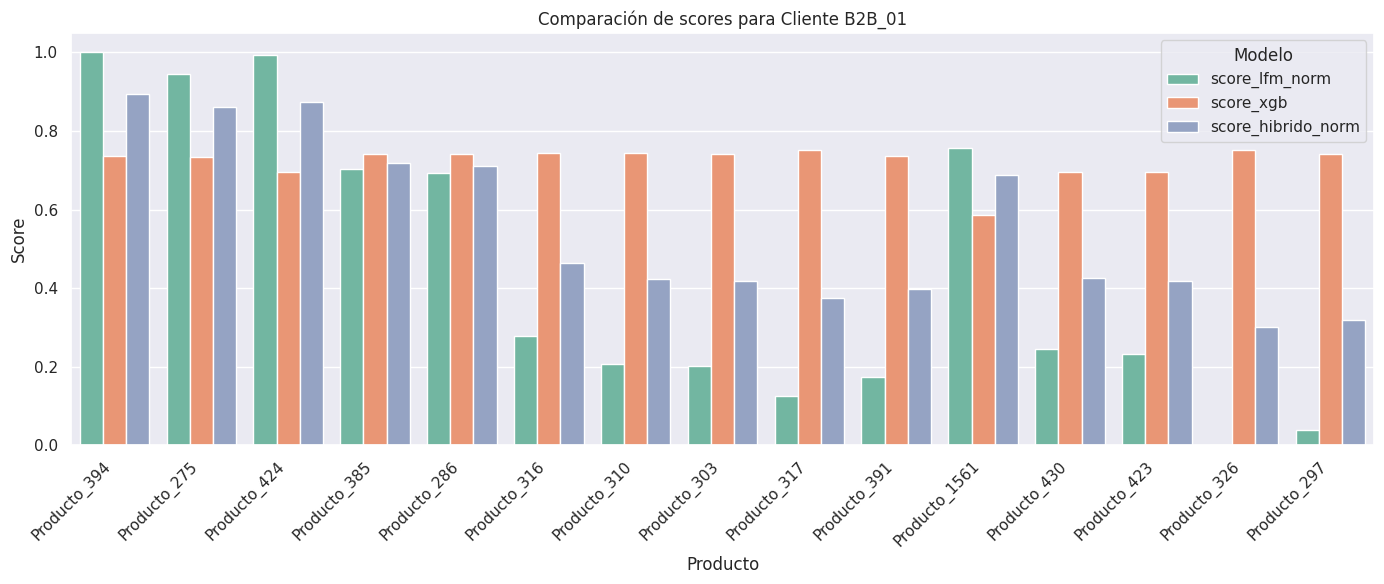


Top 5 mayores diferencias de ranking (XGBoost vs LightFM):
           producto  rank_lfm  rank_xgb  rank_diff
1746   Producto_326      15.0       1.5      -13.5
1524   Producto_317      13.0       1.5      -11.5
1786   Producto_424       2.0      13.0       11.0
1874  Producto_1561       4.0      15.0       11.0
349    Producto_394       1.0       9.5        8.5


In [29]:
comparar_modelos_b2b(cliente_id="B2B_01", top_n=15, alpha=0.6)



## Comparacion modelos sin Extras

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def comparar_modelos_b2b_SinExtras(cliente_id, top_n=30, alpha=0.5, normalizar_lfm=True):
    df_scores = recomendar_hibrido_b2b_SinExtras(cliente_id=cliente_id, top_n=top_n, alpha=alpha)

    if isinstance(df_scores, str):
        print(df_scores)
        return

    # --- Normalizar LightFM si se requiere ---
    if normalizar_lfm:
        min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
        df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
        df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']
        cols_plot = ['score_lfm_norm', 'score_xgb', 'score_hibrido_norm']
    else:
        cols_plot = ['score_lfm', 'score_xgb', 'score_hibrido']

    # --- Estadísticas descriptivas ---
    print("Estadísticas de scores:\n")
    for col in cols_plot:
        print(f"{col}:\n{df_scores[col].describe()}\n")

    # --- Gráfico comparativo ---
    df_plot = df_scores.melt(id_vars='producto', value_vars=cols_plot,
                             var_name='modelo', value_name='score')

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparación de scores para Cliente {cliente_id}")
    plt.ylabel("Score")
    plt.xlabel("Producto")
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

    # --- Comparación de rankings ---
    df_scores['rank_lfm'] = df_scores['score_lfm'].rank(ascending=False)
    df_scores['rank_xgb'] = df_scores['score_xgb'].rank(ascending=False)
    df_scores['rank_diff'] = df_scores['rank_xgb'] - df_scores['rank_lfm']

    print("\nTop 5 mayores diferencias de ranking (XGBoost vs LightFM):")
    print(df_scores[['producto', 'rank_lfm', 'rank_xgb', 'rank_diff']].sort_values('rank_diff', key=abs, ascending=False).head())


Estadísticas de scores:

score_lfm_norm:
count    15.000000
mean      0.419887
std       0.402058
min       0.000000
25%       0.077923
50%       0.131185
75%       0.836872
max       1.000000
Name: score_lfm_norm, dtype: float64

score_xgb:
count    15.000000
mean      0.691864
std       0.058482
min       0.486853
25%       0.700821
50%       0.707740
75%       0.714577
max       0.726932
Name: score_xgb, dtype: float64

score_hibrido_norm:
count    15.000000
mean      0.528678
std       0.232637
min       0.282393
25%       0.331717
50%       0.361807
75%       0.763508
max       0.886698
Name: score_hibrido_norm, dtype: float64



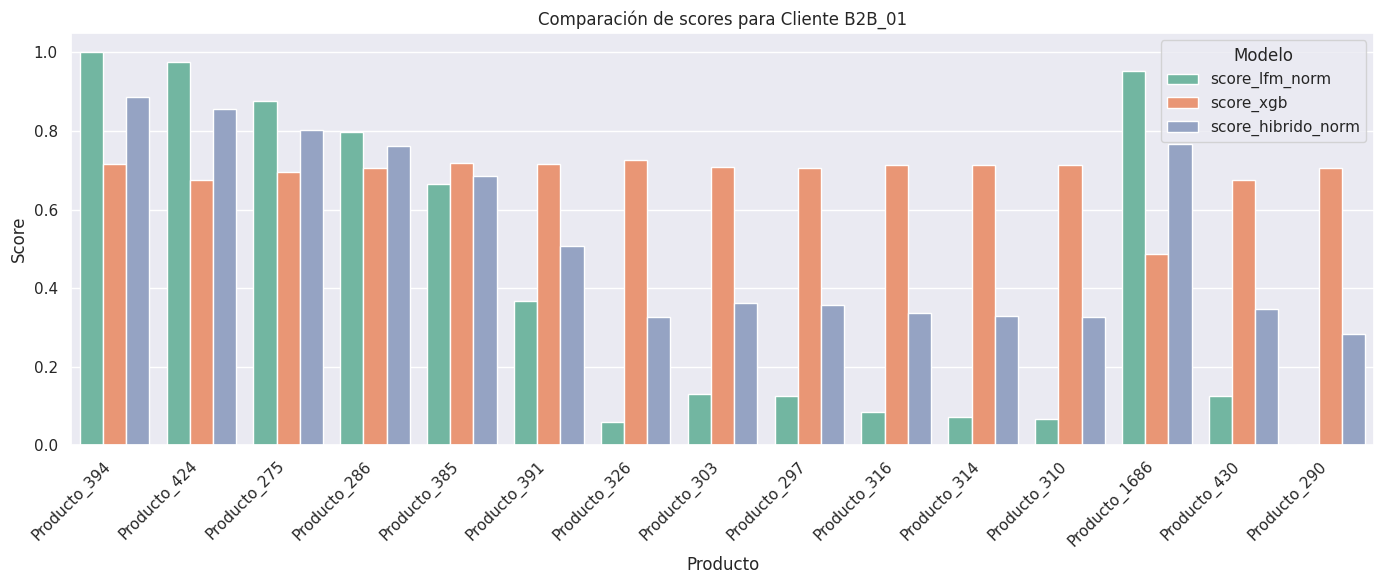


Top 5 mayores diferencias de ranking (XGBoost vs LightFM):
           producto  rank_lfm  rank_xgb  rank_diff
1746   Producto_326      14.0       1.0      -13.0
1624  Producto_1686       3.0      15.0       12.0
1786   Producto_424       2.0      13.5       11.5
1373   Producto_275       4.0      12.0        8.0
1357   Producto_310      13.0       6.0       -7.0


In [31]:
comparar_modelos_b2b_SinExtras(cliente_id="B2B_01", top_n=15, alpha=0.6)


## Exportar todos los modelos realizados

In [32]:
# import joblib
# import os

# # Crear carpeta si no existe
# os.makedirs("modelos", exist_ok=True)

# # Guardar modelos B2B
# joblib.dump(model, 'modelos/b2b_model_xgb.json')
# joblib.dump(model_lfm, 'modelos/b2b_model_lfm.json')
# joblib.dump(dataset, 'modelos/b2b_dataset.json')
# joblib.dump(user_features, 'modelos/b2b_user_features.json')
# joblib.dump(item_features, 'modelos/b2b_item_features.json')
# joblib.dump(encoders, 'modelos/b2b_encoders.json')

# print("Modelos y objetos B2B guardados correctamente.")


In [33]:
# from google.colab import files
# files.download('modelos/b2b_model_xgb.json')
# files.download('modelos/b2b_model_lfm.json')
# files.download('modelos/b2b_dataset.json')
# files.download('modelos/b2b_user_features.json')
# files.download('modelos/b2b_item_features.json')
# files.download('modelos/b2b_encoders.json')


## Precios


In [34]:
# Extraer precios de los productos
# Agrupar por producto y calcular el promedio del valor total
precios_productos = b2b[['producto', 'valor_total']].copy()
precios_productos_promedio = precios_productos.groupby('producto')['valor_total'].mean().reset_index()
precios_productos_promedio = precios_productos_promedio.rename(columns={'valor_total': 'precio_promedio'})

# Guardar en un dataframe
df_precios_productos = precios_productos_promedio

print("DataFrame con precios promedio por producto:")
print(df_precios_productos.head())

# Puedes verificar si hay productos repetidos con diferente precio en el dataframe original antes del groupby
productos_con_precios_varios = b2b.groupby('producto')['valor_total'].nunique()
productos_con_precios_varios = productos_con_precios_varios[productos_con_precios_varios > 1].index.tolist()

if productos_con_precios_varios:
    print("\nProductos con diferentes precios (se calculó el promedio):")
    print(productos_con_precios_varios)
else:
    print("\nNo se encontraron productos con precios diferentes en los datos originales.")


DataFrame con precios promedio por producto:
        producto  precio_promedio
0     Producto_1      3157.516002
1    Producto_10       127.521962
2   Producto_100      1663.522049
3  Producto_1000       283.441552
4  Producto_1001      2094.794838

Productos con diferentes precios (se calculó el promedio):
['Producto_1', 'Producto_10', 'Producto_100', 'Producto_1000', 'Producto_1001', 'Producto_1002', 'Producto_1003', 'Producto_1004', 'Producto_1005', 'Producto_1006', 'Producto_1007', 'Producto_1008', 'Producto_1009', 'Producto_101', 'Producto_1010', 'Producto_1011', 'Producto_1012', 'Producto_1013', 'Producto_1015', 'Producto_1016', 'Producto_1017', 'Producto_1019', 'Producto_102', 'Producto_1020', 'Producto_1021', 'Producto_1023', 'Producto_1024', 'Producto_1025', 'Producto_1026', 'Producto_1027', 'Producto_1028', 'Producto_1029', 'Producto_103', 'Producto_1030', 'Producto_1031', 'Producto_1032', 'Producto_1033', 'Producto_1034', 'Producto_1035', 'Producto_1036', 'Producto_1037', 'P

In [35]:
# Assuming the previous code block has been executed and variables like
# b2b, model_lfm, user_features, item_features, model, encoders, and df_precios_productos are available.

def recomendar_hibrido_con_info(cliente_id, df_original, model_lfm, user_features, item_features, model_xgb, encoders, df_precios, top_n=10, alpha=0.5):
    """
    Recomienda productos de forma híbrida (LightFM + XGBoost) para un cliente
    y reporta precio, valor esperado y alineación estratégica.

    Args:
        cliente_id (str): ID del cliente.
        df_original (pd.DataFrame): DataFrame original con todos los datos (incluye 'precio_promedio' y 'alineación con portafolio estratégico b2b').
        model_lfm (LightFM): Modelo LightFM entrenado.
        user_features: User features para LightFM.
        item_features: Item features para LightFM.
        model_xgb (xgb.XGBClassifier): Modelo XGBoost entrenado.
        encoders (dict): Diccionario de LabelEncoders usados para el modelo XGBoost.
        df_precios (pd.DataFrame): DataFrame con los precios promedio por producto.
        top_n (int): Número de recomendaciones a retornar.
        alpha (float): Ponderación para el score de LightFM en el score híbrido (0 <= alpha <= 1).

    Returns:
        pd.DataFrame: DataFrame con las recomendaciones, scores, precio, valor esperado y alineación.
                      Retorna un string si el cliente no se encuentra.
    """
    # Validar existencia del cliente en LightFM
    # Necesitamos acceder al objeto dataset original usado para LightFM para el mapping
    # Asumimos que el objeto `dataset` del pipeline LightFM con extras está disponible
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM (completo)."

    # Productos ya comprados
    productos_comprados = set(df_original[df_original['id_b2b'] == cliente_id]['producto'].unique())
    productos_totales = df_original['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # --- LightFM ---
    usuario_interno = dataset.mapping()[0][cliente_id]
    # Filtrar productos candidatos que también estén en el mapping de LightFM
    productos_idx = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    productos_candidatos_filtrados = [p for p in productos_candidatos if p in dataset.mapping()[2]]


    # Verificar si hay productos candidatos después del filtrado
    if not productos_idx:
         return f"No hay productos candidatos disponibles en el dataset LightFM para recomendar al cliente {cliente_id}."


    scores_lfm = model_lfm.predict(
        user_ids=np.repeat(usuario_interno, len(productos_idx)),
        item_ids=productos_idx,
        user_features=user_features,
        item_features=item_features
    )

    df_lfm = pd.DataFrame({
        'producto': productos_candidatos_filtrados, # Usar la lista filtrada
        'score_lfm': scores_lfm
    })

    # --- XGBoost ---
    # Tomar una muestra representativa del cliente del dataframe original
    cliente_info = df_original[df_original['id_b2b'] == cliente_id].iloc[0]
    nuevas_filas = []

    for producto in df_lfm['producto']: # Usar productos del df_lfm
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Asegurarse de que las columnas necesarias para el encoder estén presentes
    cat_cols_encoders = list(encoders.keys())
    for col in cat_cols_encoders:
        if col not in pred_df.columns:
             # Intentar obtener la columna de la info del cliente o dejarla faltante si no es una feature del cliente
             if col in cliente_info.index:
                  pred_df[col] = cliente_info[col]
             # Si es una columna de producto, ya se añadió al crear las filas.
             # Si no es ni de cliente ni de producto, podría faltar.
             # Aquí asumimos que las columnas de los encoders están en cliente_info o en las columnas añadidas.
             # Si hay errores, se podría añadir manejo específico para columnas faltantes.


    # Codificar con los mismos encoders usados en XGBoost
    for col in encoders:
        if col in pred_df.columns:
            try:
                 pred_df[col] = encoders[col].transform(pred_df[col].astype(str)) # Asegurar tipo string para transform
            except ValueError as e:
                 print(f"Error al codificar la columna '{col}': {e}")
                 print(f"Valores únicos en la columna '{col}' antes de codificar: {pred_df[col].unique()}")
                 # Manejar el error, quizás re-fit o skip dependiendo de la estrategia
                 pass


    # Predecir con XGBoost
    # Asegurarse de que las columnas de X_pred coinciden con las feature_names del booster
    xgb_feature_names = model_xgb.get_booster().feature_names
    X_pred = pred_df[xgb_feature_names]
    scores_xgb = model_xgb.predict_proba(X_pred)[:, 1]

    # --- Combinar scores ---
    # Normalizar LFM si hay más de un score y no son todos iguales
    if df_lfm['score_lfm'].nunique() > 1:
        min_lfm = df_lfm['score_lfm'].min()
        max_lfm = df_lfm['score_lfm'].max()
        df_lfm['score_lfm_norm'] = (df_lfm['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
    else:
        df_lfm['score_lfm_norm'] = 0.5 # Valor por defecto si todos los scores son iguales

    # Unir scores de XGBoost
    df_lfm['score_xgb'] = scores_xgb
    df_lfm['score_hibrido'] = alpha * df_lfm['score_lfm_norm'] + (1 - alpha) * df_lfm['score_xgb']

    # --- Agregar información de precio y alineación estratégica ---
    # Unir con el dataframe de precios promedio
    df_recomendaciones = df_lfm.merge(df_precios, on='producto', how='left')

    # Agregar la columna de alineación estratégica del dataframe original
    # Necesitamos la alineación por producto. Podemos obtenerla del df_original agrupando por producto
    alineacion_productos = df_original.drop_duplicates('producto')[['producto', 'alineación con portafolio estratégico b2b']]
    df_recomendaciones = df_recomendaciones.merge(alineacion_productos, on='producto', how='left')


    # Calcular el valor esperado
    df_recomendaciones['valor_esperado'] = df_recomendaciones['score_hibrido'] * df_recomendaciones['precio_promedio']


    # Ordenar por score híbrido y seleccionar top_n
    df_recomendaciones = df_recomendaciones.sort_values('score_hibrido', ascending=False).head(top_n)

    # Seleccionar y renombrar columnas finales
    return df_recomendaciones[[
        'producto',
        'score_hibrido',
        'precio_promedio',
        'valor_esperado',
        'alineación con portafolio estratégico b2b'
    ]]

# Ejemplo de uso de la nueva función:
recomendaciones_completas = recomendar_hibrido_con_info(
    cliente_id="B2B_01",
    df_original=b2b, # Pasamos el dataframe original completo
    model_lfm=model_lfm,
    user_features=user_features,
    item_features=item_features,
    model_xgb=model, # Usamos el modelo XGBoost entrenado con extras
    encoders=encoders, # Usamos los encoders del modelo XGBoost entrenado con extras
    df_precios=df_precios_productos, # Pasamos el dataframe de precios
    top_n=10,
    alpha=0.6 # Ajusta el alpha según necesites
)

print("\nRecomendaciones con información adicional:")
recomendaciones_completas



Recomendaciones con información adicional:


,producto,score_hibrido,precio_promedio,valor_esperado,alineación con portafolio estratégico b2b
349,Producto_394,0.838504,1997.045347,1674.530901,0.000244
1373,Producto_275,0.832396,207.845752,173.010041,0.000283
1786,Producto_424,0.822204,2413.236223,1984.171310,0.000285
302,Producto_385,0.812990,242.879971,197.458918,0.000285
110,Producto_286,0.811293,1148.888592,932.084868,0.000329
1189,Producto_316,0.773290,5249.250202,4059.194766,0.000343
1357,Producto_310,0.766606,3181.705652,2439.115696,0.000290
1612,Producto_303,0.764600,334.968357,256.116759,0.000347
1524,Producto_317,0.761157,5372.747524,4089.502658,0.000338
869,Producto_391,0.759657,663.454202,503.997567,0.000198


## Calculo del valor esperado Ingresos

In [36]:
# Filtrar solo scores positivos
val_positivos = recomendaciones_completas[recomendaciones_completas['score_hibrido'] > 0].copy()

# Calcular el valor esperado como SumaProducto
valor_esperado = (val_positivos['score_hibrido'] * val_positivos['precio_promedio']).sum()

print(f"Valor esperado total: {valor_esperado:.2f}")

Valor esperado total: 16309.18


## Tasa de alineacion estrategica

In [37]:
tasa_alta = (recomendaciones_completas['alineación con portafolio estratégico b2b'].astype(float) > 0.0002).mean()
print(f" % de recomendaciones con alta alineación estratégica: {tasa_alta:.2%}")



 % de recomendaciones con alta alineación estratégica: 90.00%


## Top producto mas recomendado

In [38]:
top_productos = recomendaciones_completas['producto'].value_counts().head(5)
print("Top 5 productos más recomendados:")
print(top_productos)


Top 5 productos más recomendados:
producto
Producto_394    1
Producto_275    1
Producto_424    1
Producto_385    1
Producto_286    1
Name: count, dtype: int64


In [47]:
# Obtener la lista de clientes únicos
clientes_unicos = b2b['id_b2b'].unique()

# DataFrame para almacenar los resultados por cliente
resultados_por_cliente = []

# Iterar sobre cada cliente único
for cliente_id in clientes_unicos:
    print(f"Procesando cliente: {cliente_id}")

    # 1. Calcular recomendaciones con el modelo híbrido
    recomendaciones = recomendar_hibrido_con_info(
        cliente_id=cliente_id,
        df_original=b2b,
        model_lfm=model_lfm,
        user_features=user_features,
        item_features=item_features,
        model_xgb=model,
        encoders=encoders,
        df_precios=df_precios_productos,
        top_n=10, # Ajusta top_n según la cantidad de recomendaciones que quieras por cliente
        alpha=0.6 # Ajusta el alpha según tu preferencia
    )

    # Verificar si la función retornó un string (cliente no encontrado o sin candidatos)
    if isinstance(recomendaciones, str):
        print(recomendaciones)
        continue # Pasar al siguiente cliente

    # Asegurarse de que 'alineación con portafolio estratégico b2b' es numérico para el cálculo de tasa
    recomendaciones['alineación con portafolio estratégico b2b'] = pd.to_numeric(
        recomendaciones['alineación con portafolio estratégico b2b'], errors='coerce'
    )

    # 2. Calcular valor esperado (suma de score * precio)
    # Consideramos solo recomendaciones con score híbrido > 0 para el valor esperado
    val_positivos = recomendaciones[recomendaciones['score_hibrido'] > 0].copy()
    valor_esperado = (val_positivos['score_hibrido'] * val_positivos['precio_promedio']).sum()

    # 3. Calcular tasa de alineación con el portafolio estratégico
    # Consideramos "alta alineación" un valor estratégico > 0.0002
    tasa_alta_alineacion = (recomendaciones['alineación con portafolio estratégico b2b'] > 0.0002).mean()

    # 4. Promedio de alineaciones estrategicas
    promedio_alineacion = recomendaciones['alineación con portafolio estratégico b2b'].mean()

    # Almacenar los resultados
    resultados_por_cliente.append({
        'cliente_id': cliente_id,
        'recomendaciones': recomendaciones.to_dict('records'), # Almacenar las recomendaciones como lista de diccionarios
        'valor_esperado_total': valor_esperado,
        'tasa_alta_alineacion': tasa_alta_alineacion,
        'promedio_alineacion': promedio_alineacion
    })

# Opcional: Convertir la lista de resultados a un DataFrame para mejor visualización general
df_resultados = pd.DataFrame(resultados_por_cliente)

print("\nResumen de resultados por cliente:")
print(df_resultados[['cliente_id', 'valor_esperado_total', 'tasa_alta_alineacion', 'promedio_alineacion']].head()) # Mostrar un resumen

# Si quieres ver las recomendaciones detalladas para un cliente específico, puedes acceder a 'df_resultados'
# Por ejemplo, para el primer cliente:
# print("\nRecomendaciones detalladas para el primer cliente en el resumen:")
# print(pd.DataFrame(df_resultados.iloc[0]['recomendaciones']))

# Para exportar los resultados si es necesario
# df_resultados.to_csv('resultados_recomendaciones_clientes.csv', index=False)
# df_resultados.to_json('resultados_recomendaciones_clientes.json', orient='records')


Procesando cliente: B2B_01
Procesando cliente: B2B_02
Procesando cliente: B2B_03
Procesando cliente: B2B_04
Procesando cliente: B2B_05
Procesando cliente: B2B_06

Resumen de resultados por cliente:
  cliente_id  valor_esperado_total  tasa_alta_alineacion  promedio_alineacion
0     B2B_01          16309.183484                   0.9             0.000294
1     B2B_02          23437.598890                   0.8             0.000287
2     B2B_03           4283.182339                   0.8             0.000264
3     B2B_04           4006.329817                   0.9             0.000285
4     B2B_05           4914.069545                   0.8             0.000337


In [48]:
import pandas as pd
# Mostrar las recomendaciones calculadas para el primer cliente en el resumen
# que contiene la tasa de alineación estratégica.
if not df_resultados.empty:
  primer_cliente_resultados = df_resultados.iloc[0]
  print("\nRecomendaciones para el primer cliente en el resumen:")
  print(pd.DataFrame(primer_cliente_resultados['recomendaciones']))
  print(f"\nTasa de alta alineación estratégica para {primer_cliente_resultados['cliente_id']}: {primer_cliente_resultados['tasa_alta_alineacion']:.2%}")
else:
  print("\nNo hay resultados por cliente disponibles para mostrar.")



Recomendaciones para el primer cliente en el resumen:
       producto  score_hibrido  precio_promedio  valor_esperado  \
0  Producto_394       0.838504      1997.045347     1674.530901   
1  Producto_275       0.832396       207.845752      173.010041   
2  Producto_424       0.822204      2413.236223     1984.171310   
3  Producto_385       0.812990       242.879971      197.458918   
4  Producto_286       0.811293      1148.888592      932.084868   
5  Producto_316       0.773290      5249.250202     4059.194766   
6  Producto_310       0.766606      3181.705652     2439.115696   
7  Producto_303       0.764600       334.968357      256.116759   
8  Producto_317       0.761157      5372.747524     4089.502658   
9  Producto_391       0.759657       663.454202      503.997567   

   alineación con portafolio estratégico b2b  
0                                   0.000244  
1                                   0.000283  
2                                   0.000285  
3                  

## Interfaz provisional

In [40]:
# Librerías
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Widgets de entrada
id_input = widgets.Text(
    value='B2B_01',
    placeholder='ID del cliente',
    description='Cliente ID:',
    disabled=False
)

topn_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=30,
    step=1,
    description='Top-N:',
    continuous_update=False
)

alpha_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Peso LFM (α):',
    continuous_update=False
)

btn = widgets.Button(description="Comparar Modelos")
output = widgets.Output()

# Función principal
def on_click(b):
    output.clear_output()
    with output:
        try:
            cliente_id = id_input.value.strip()
            topn = topn_slider.value
            alpha = alpha_slider.value

            df_scores = recomendar_hibrido_b2b(cliente_id=cliente_id, top_n=topn, alpha=alpha)

            if isinstance(df_scores, str):
                print(df_scores)
                return

            # Normalizar LightFM
            min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
            df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
            df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']

            # Gráfico de scores
            df_plot = df_scores.melt(
                id_vars='producto',
                value_vars=['score_lfm_norm', 'score_xgb', 'score_hibrido_norm'],
                var_name='modelo', value_name='score'
            )

            plt.figure(figsize=(14, 6))
            sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Blues')
            plt.title(f"Comparación de scores normalizados para Cliente {cliente_id}")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # Tabla con score promedio
            df_scores['score_promedio'] = df_scores[['score_lfm', 'score_xgb']].mean(axis=1)
            tabla = df_scores[['producto', 'score_lfm', 'score_xgb', 'score_promedio']].sort_values(
                'score_promedio', ascending=False).reset_index(drop=True)
            display(tabla)

            # Imprimir métricas de cada modelo por separado
            print("\nMétricas del modelo XGBoost:")
            for k, v in metricas_xgb_b2b.items():
                print(f"{k}: {v:.4f}")

            print("\nMétricas del modelo LightFM:")
            for k, v in metricas_lfm_b2b.items():
                print(f"{k}: {v:.4f}")

            print("\nMétricas del modelo Híbrido:")
            for k, v in metricas_hibrido_b2b.items():
                print(f"{k}: {v:.4f}")

        except Exception as e:
            print(f"Error: {e}")

btn.on_click(on_click)

# Mostrar interfaz
display(widgets.VBox([
    id_input,
    topn_slider,
    alpha_slider,
    btn,
    output
]))
